## In This Project I will solve Nonlinear dispersive Schrödinger equation using Physics-Informed Neural Networks (PINNs)

---

### Nonlinear Schrödinger Equation (NLSE)

The **Nonlinear Schrödinger Equation (NLSE)** is a fundamental equation in physics that describes the evolution of complex wave fields in nonlinear and dispersive media. It has applications in fields like fiber optics, plasma physics, Bose-Einstein condensates, and fluid dynamics.

---

### General Form of the NLSE

The equation can be written as:

$$
i \frac{\partial \psi}{\partial t} + \alpha \frac{\partial^2 \psi}{\partial x^2} + \beta |\psi|^2 \psi = 0
$$

Where:
$$
i  \psi = \psi(\mathbf{x}, t) \: Complex-valued wave function.
$$

$$
t : Time.
$$

$$
\alpha : Dispersion  coefficient.
$$

$$
\beta : Nonlinear coefficient.
$$


---

### **Physical Interpretations**

- Dispersion Term $ \alpha \nabla^2 \psi :$ Models the spreading of the wave packet due to dispersion.
- Nonlinearity Term $ \beta |\psi|^2 \psi $ Describes self-focusing or self-defocusing effects depending on the sign of $ \beta $.
- Time Derivative $ i \frac{\partial \psi}{\partial t} $ Captures the evolution of the wave function in time.

---



### Import libraries

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

### Creating our Physical-Informed Neural Network

In [9]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.network = nn.Sequential()
        for i in range(len(layers) - 1):
            self.network.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.network.append(nn.Softsign())

    def forward(self, x, t):
        input_tensor = torch.cat((x, t), dim=1)
        return self.network(input_tensor)

### Analytical Solutions

In [11]:
def soliton_solution(x, t, alpha=1.0, beta=1.0):
    """
    Generate analytical soliton solution for NLSE
    """
    A = 1.0  # Amplitude
    v = 0.5  # Velocity
    
    xi = x - v*t
    phi = A / np.cosh(np.sqrt(A) * xi / (2 * np.sqrt(alpha)))
    
    psi_real = phi * np.cos(beta * phi**2 * t)
    psi_imag = phi * np.sin(beta * phi**2 * t)
    
    return psi_real, psi_imag

def gaussian_solution(x, t, alpha=1.0, beta=1.0):
    """
    Generate analytical Gaussian solution for NLSE
    """
    sigma = 0.5  # Width
    k0 = 2.0     # Initial wave number
    
    sigma_t = np.sqrt(sigma**2 + 2j * alpha * t)
    
    psi_real = (1 / np.sqrt(sigma_t)) * np.exp(-(x**2 / (2 * sigma_t**2)) + 1j * k0 * x - 1j * k0**2 * t)
    psi_imag = np.imag(psi_real)
    psi_real = np.real(psi_real)
    
    return psi_real, psi_imag

def periodic_solution(x, t, alpha=1.0, beta=1.0):
    """
    Generate analytical periodic solution for NLSE
    """
    A = 1.0  # Amplitude
    omega = 2.0  # Frequency
    
    psi_real = A * np.sin(omega * x + beta * A**2 * t)
    psi_imag = A * np.cos(omega * x + beta * A**2 * t)
    
    return psi_real, psi_imag

### Losses

In [12]:
def calculate_l2_norm(solution1, solution2):
    """
    Calculate L2-norm between two solutions
    """
    difference = solution1 - solution2
    l2_norm = np.sqrt(np.mean(np.abs(difference)**2))
    return l2_norm

def loss_function(model, x, t, alpha, beta, psi_initial):
    x = x.clone().requires_grad_(True)
    t = t.clone().requires_grad_(True)

    psi = model(x, t)
    psi_real, psi_imag = psi[:, 0:1], psi[:, 1:2]

    def safe_grad(output, input_tensor):
        return torch.autograd.grad(
            output, 
            input_tensor, 
            grad_outputs=torch.ones_like(output),
            create_graph=True,
            retain_graph=True
        )[0]

    psi_real_t = safe_grad(psi_real, t)
    psi_imag_t = safe_grad(psi_imag, t)
    
    psi_real_x = safe_grad(psi_real, x)
    psi_imag_x = safe_grad(psi_imag, x)
    
    psi_real_xx = safe_grad(psi_real_x, x)
    psi_imag_xx = safe_grad(psi_imag_x, x)

    nonlinear_term = psi_real**2 + psi_imag**2
    
    real_residual = psi_real_t + alpha * psi_imag_xx + beta * nonlinear_term * psi_imag
    imag_residual = psi_imag_t - alpha * psi_real_xx - beta * nonlinear_term * psi_real

    pde_loss = torch.mean(torch.abs(real_residual)**2 + torch.abs(imag_residual)**2)
    
    initial_psi = model(x, torch.zeros_like(t))
    initial_loss = torch.mean(torch.abs(initial_psi - psi_initial)**2)

    # Calculate L2 norm with analytical solution at training points
    with torch.no_grad():
        analytical_real, analytical_imag = soliton_solution(x.numpy(), t.numpy())
        analytical_real = torch.tensor(analytical_real, dtype=torch.float32)
        analytical_imag = torch.tensor(analytical_imag, dtype=torch.float32)
        
        l2_loss = torch.mean(torch.abs(psi_real - analytical_real)**2 + 
                           torch.abs(psi_imag - analytical_imag)**2)

    total_loss = pde_loss + initial_loss + 0.1 * l2_loss

    return total_loss, l2_loss.item()

### Training NN

In [13]:
def train_pinn(num_epochs=20000, learning_rate=0.001):
    torch.manual_seed(42)
    np.random.seed(42)

    layers = [2, 128, 128, 128, 2]
    alpha = 1.0
    beta = 1.0

    num_points = 5000
    x = torch.rand((num_points, 1)) * 4 - 2
    t = torch.rand((num_points, 1)) * 4 - 2

    psi_initial = torch.sin(np.pi * x) * torch.exp(-x**2) * torch.cos(0.5 * np.pi * x) * (1 + 0.1 * x**2)

    model = PINN(layers)
    model.apply(lambda m: xavier_init(m) if isinstance(m, nn.Linear) else None)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500, factor=0.5, min_lr=1e-5)

    losses = []
    l2_losses = []
    best_loss = float('inf')
    patience = 1000
    counter = 0

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        try:
            loss, l2_loss = loss_function(model, x, t, alpha, beta, psi_initial)
            
            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch}")
                break

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            loss.backward()
            optimizer.step()

            scheduler.step(loss)

            current_loss = loss.item()
            losses.append(current_loss)
            l2_losses.append(l2_loss)

            if current_loss < best_loss:
                best_loss = current_loss
                counter = 0
            else:
                counter += 1

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {current_loss:.4e}, L2 Loss: {l2_loss:.4e}")

            if counter > patience:
                print(f"Early stopping at epoch {epoch}")
                break

        except Exception as e:
            print(f"Error at epoch {epoch}: {e}")
            break

    return model, losses, l2_losses, x, t, psi_initial

def xavier_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

### Visualizing our work

In [16]:
def visualize_results(model, x, t, psi_initial, losses, l2_losses):
    x_grid = torch.linspace(-2, 2, 200).view(-1, 1)
    t_grid = torch.linspace(-2, 2, 200).view(-1, 1)
    X, T = torch.meshgrid(x_grid.squeeze(), t_grid.squeeze())
    
    X_flat = X.reshape(-1, 1)
    T_flat = T.reshape(-1, 1)
    
    with torch.no_grad():
        predictions = model(X_flat, T_flat)
    
    pinn_real = predictions[:, 0].reshape(X.shape)
    pinn_imag = predictions[:, 1].reshape(X.shape)
    pinn_magnitude = torch.sqrt(pinn_real**2 + pinn_imag**2)

    solutions = [
        ('Soliton', soliton_solution(X.numpy(), T.numpy())),
        ('Gaussian', gaussian_solution(X.numpy(), T.numpy())),
        ('Periodic', periodic_solution(X.numpy(), T.numpy()))
    ]

    l2_norms = {}
    for name, (real, imag) in solutions:
        analytical_magnitude = np.sqrt(real**2 + imag**2)
        l2_norm_magnitude = calculate_l2_norm(pinn_magnitude.numpy(), analytical_magnitude)
        l2_norm_real = calculate_l2_norm(pinn_real.numpy(), real)
        l2_norm_imag = calculate_l2_norm(pinn_imag.numpy(), imag)
        
        l2_norms[name] = {
            'magnitude': l2_norm_magnitude,
            'real': l2_norm_real,
            'imag': l2_norm_imag
        }

    fig, axes = plt.subplots(4, 3, figsize=(20, 25))
    
    axes[0, 0].contourf(X.numpy(), T.numpy(), pinn_magnitude.numpy(), levels=20, cmap='viridis')
    axes[0, 0].set_title('PINN Solution - Magnitude')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('t')
    
    axes[0, 1].contourf(X.numpy(), T.numpy(), pinn_real.numpy(), levels=20, cmap='coolwarm')
    axes[0, 1].set_title('PINN Solution - Real Part')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('t')
    
    axes[0, 2].contourf(X.numpy(), T.numpy(), pinn_imag.numpy(), levels=20, cmap='coolwarm')
    axes[0, 2].set_title('PINN Solution - Imaginary Part')
    axes[0, 2].set_xlabel('x')
    axes[0, 2].set_ylabel('t')

    for i, (name, (real, imag)) in enumerate(solutions, 1):
        magnitude = np.sqrt(real**2 + imag**2)
        
        axes[i, 0].contourf(X.numpy(), T.numpy(), magnitude, levels=20, cmap='viridis')
        axes[i, 0].set_title(f'{name} Solution - Magnitude')
        axes[i, 0].set_xlabel('x')
        axes[i, 0].set_ylabel('t')
        
        axes[i, 1].contourf(X.numpy(), T.numpy(), real, levels=20, cmap='coolwarm')
        axes[i, 1].set_title(f'{name} Solution - Real Part')
        axes[i, 1].set_xlabel('x')
        axes[i, 1].set_ylabel('t')
        
        axes[i, 2].contourf(X.numpy(), T.numpy(), imag, levels=20, cmap='coolwarm')
        axes[i, 2].set_title(f'{name} Solution - Imaginary Part')
        axes[i, 2].set_xlabel('x')
        axes[i, 2].set_ylabel('t')

    
    psi_analytical = soliton_solution(X, T)
    psi_analytical_magnitude = np.sqrt(psi_analytical[0]**2 + psi_analytical[1]**2)

    fig = plt.figure(figsize=(18, 5))
    
    # PINN Solution
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(X.numpy(), T.numpy(), pinn_magnitude, cmap=cm.viridis, linewidth=1, antialiased=False)
    ax1.set_title('PINN Solution')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('Ψ(x, t)')

    # Analytical Solution
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X.numpy(), T.numpy(), psi_analytical_magnitude, cmap=cm.magma, linewidth=1, antialiased=False)
    ax2.set_title('Analytical Soliton Solution')
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    ax2.set_zlabel('Ψ(x, t)')

    # Error Surface
    ax3 = fig.add_subplot(133, projection='3d')
    error = np.abs(pinn_magnitude - psi_analytical_magnitude)
    surf3 = ax3.plot_surface(X.numpy(), T.numpy(), error, cmap=cm.plasma, linewidth=1, antialiased=False)
    ax3.set_title('Absolute Error')
    ax3.set_xlabel('x')
    ax3.set_ylabel('t')
    ax3.set_zlabel('Error')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')

    plt.subplot(1, 2, 2)
    plt.plot(l2_losses)
    plt.title('L2 Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('L2 Loss')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

    # L2-norm comparison table
    plt.figure(figsize=(12, 4))
    plt.axis('off')
    
    table_data = []
    table_columns = ['Solution Type', 'Magnitude L2', 'Real Part L2', 'Imaginary Part L2']
    
    for name in l2_norms:
        table_data.append([
            name,
            f"{l2_norms[name]['magnitude']:.6e}",
            f"{l2_norms[name]['real']:.6e}",
            f"{l2_norms[name]['imag']:.6e}"
        ])
    
    plt.table(
        cellText=table_data,
        colLabels=table_columns,
        loc='center',
        cellLoc='center',
        colColours=['#f2f2f2']*len(table_columns)
    )
    
    plt.title('L2-Norm Comparison Between PINN and Analytical Solutions')
    plt.tight_layout()
    plt.show()

### Running the code

Epoch 0, Loss: 2.4648e-01, L2 Loss: 8.1357e-01
Epoch 100, Loss: 1.5256e-01, L2 Loss: 7.4136e-01
Epoch 200, Loss: 1.5016e-01, L2 Loss: 7.4707e-01
Epoch 300, Loss: 1.4728e-01, L2 Loss: 7.5264e-01
Epoch 400, Loss: 1.4413e-01, L2 Loss: 7.5805e-01
Epoch 500, Loss: 1.4264e-01, L2 Loss: 7.6267e-01
Epoch 600, Loss: 1.3971e-01, L2 Loss: 7.5023e-01
Epoch 700, Loss: 1.3726e-01, L2 Loss: 7.4447e-01
Epoch 800, Loss: 1.3638e-01, L2 Loss: 7.5302e-01
Epoch 900, Loss: 1.3531e-01, L2 Loss: 7.5317e-01
Epoch 1000, Loss: 1.3670e-01, L2 Loss: 7.5702e-01
Epoch 1100, Loss: 1.3419e-01, L2 Loss: 7.6424e-01
Epoch 1200, Loss: 1.3384e-01, L2 Loss: 7.6534e-01
Epoch 1300, Loss: 1.3324e-01, L2 Loss: 7.6623e-01
Epoch 1400, Loss: 1.3377e-01, L2 Loss: 7.6498e-01
Epoch 1500, Loss: 1.3209e-01, L2 Loss: 7.6256e-01
Epoch 1600, Loss: 1.3121e-01, L2 Loss: 7.5346e-01
Epoch 1700, Loss: 1.3155e-01, L2 Loss: 7.5869e-01
Epoch 1800, Loss: 1.3148e-01, L2 Loss: 7.6883e-01
Epoch 1900, Loss: 1.3098e-01, L2 Loss: 7.6749e-01
Epoch 2000, 

c:\Users\AlienWare\PycharmProjects\TorchNN\.venv\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


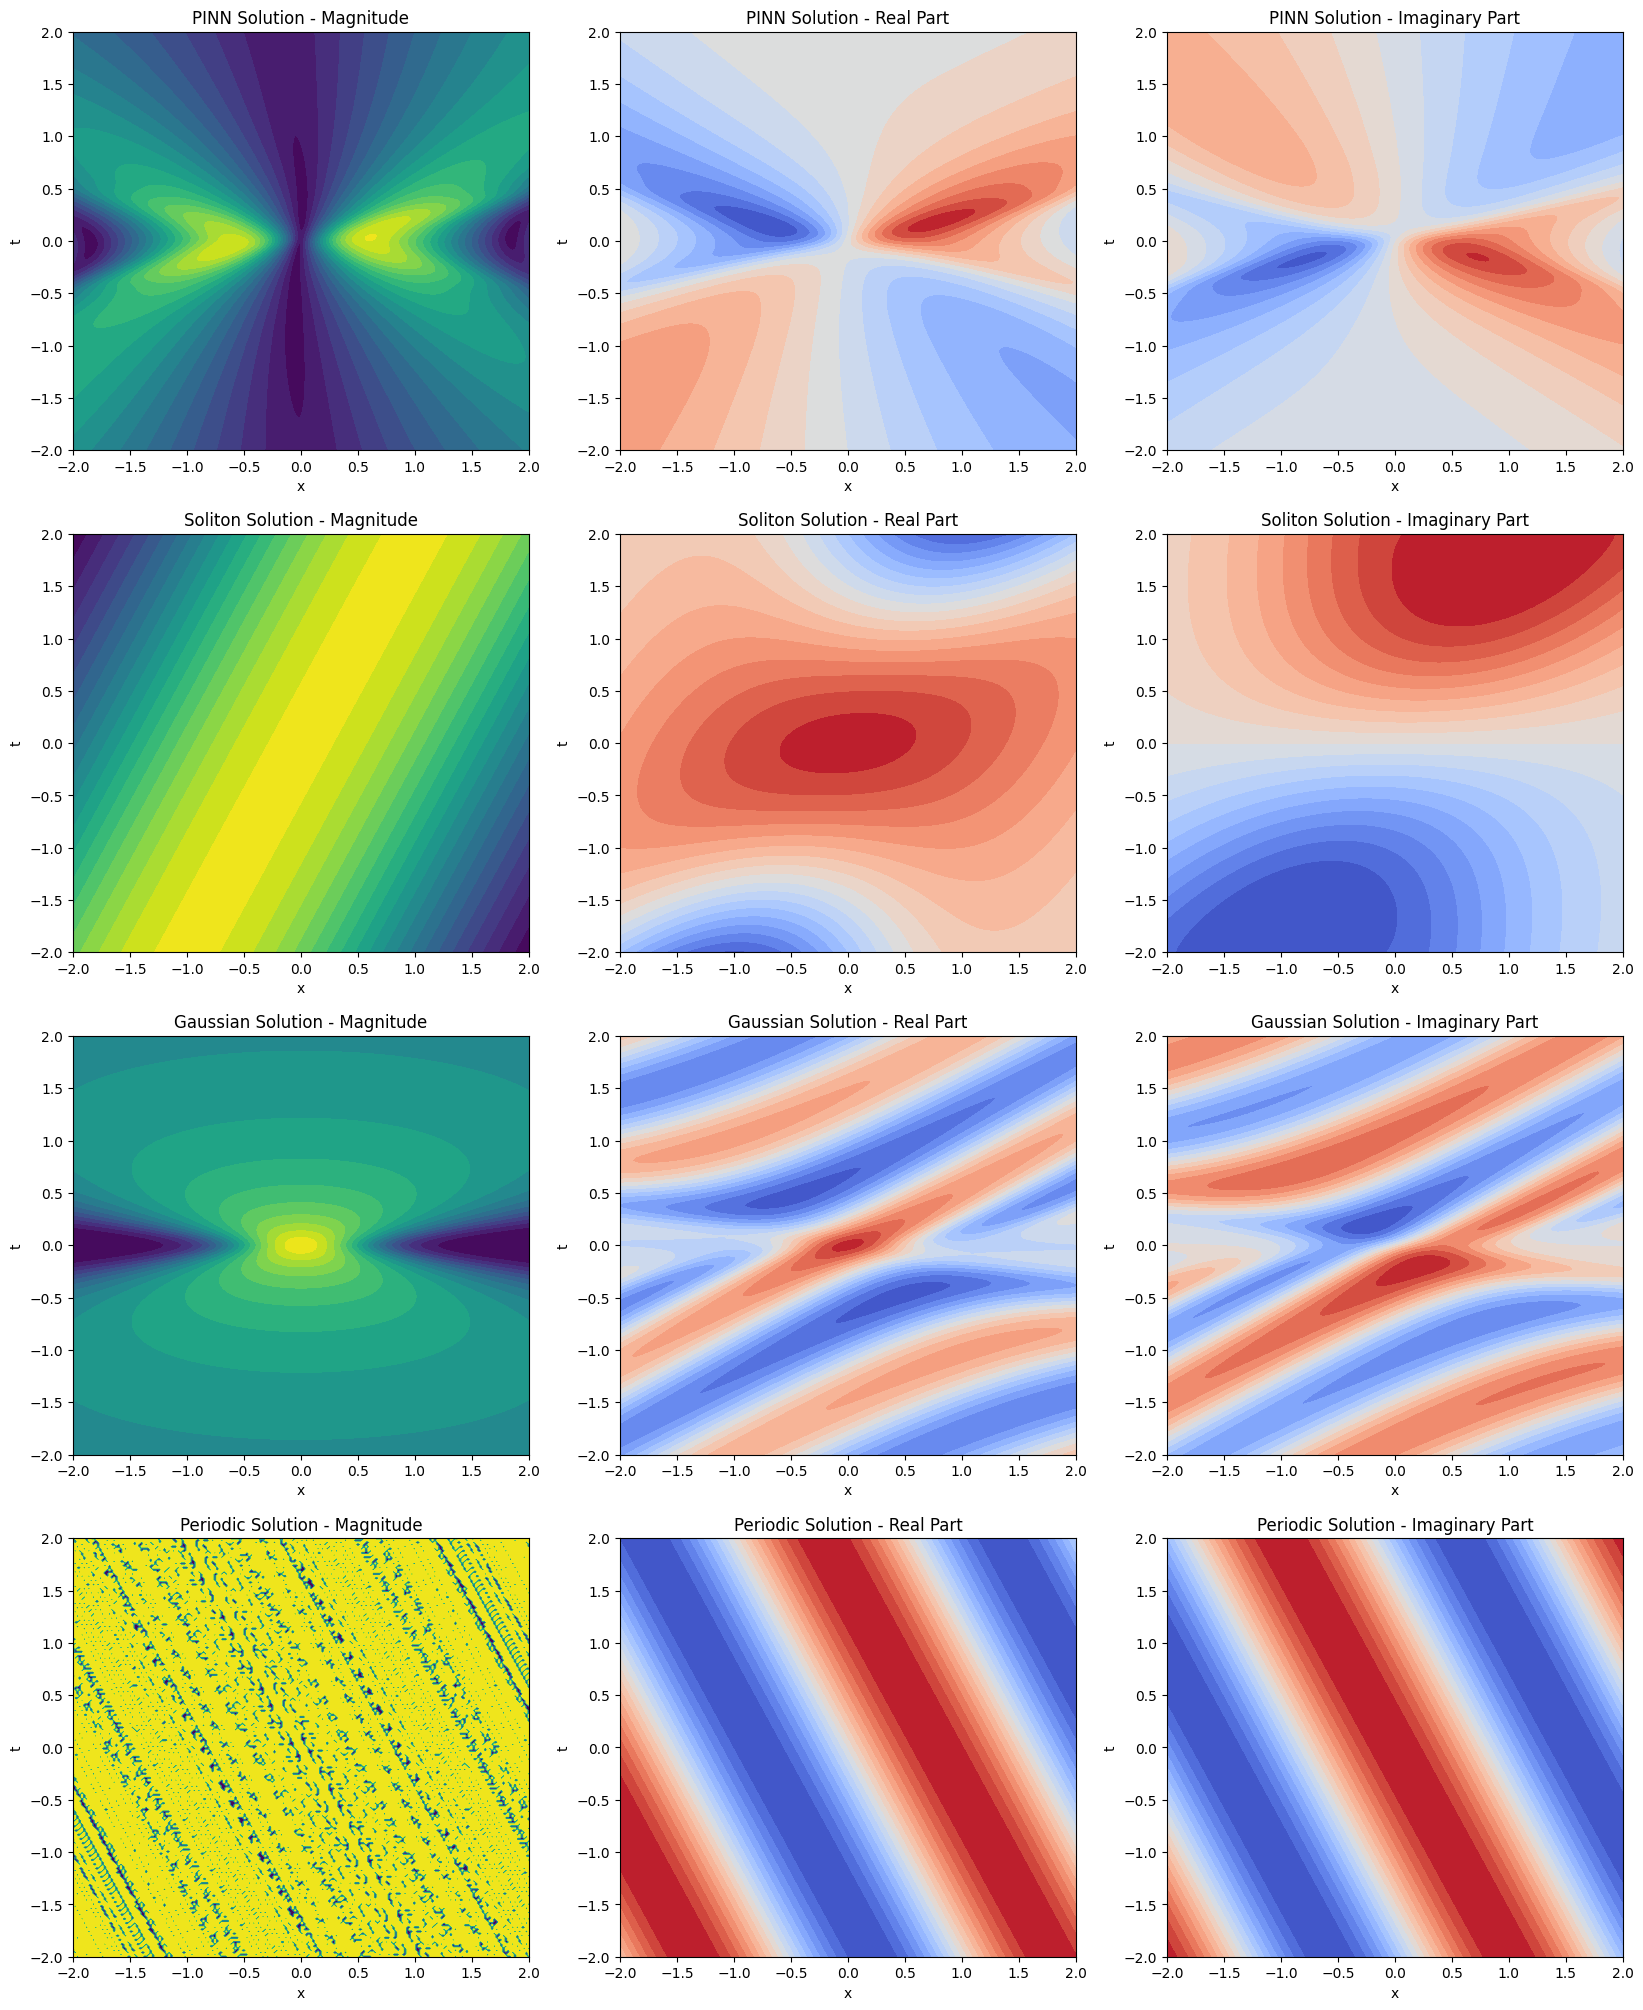

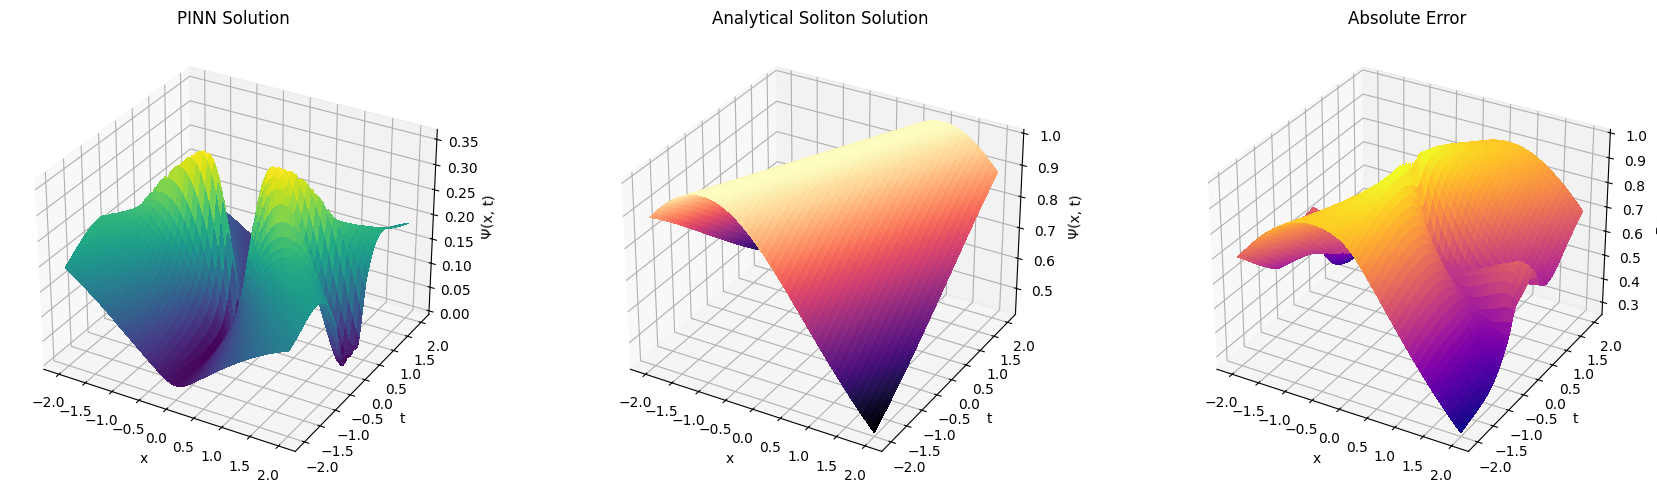

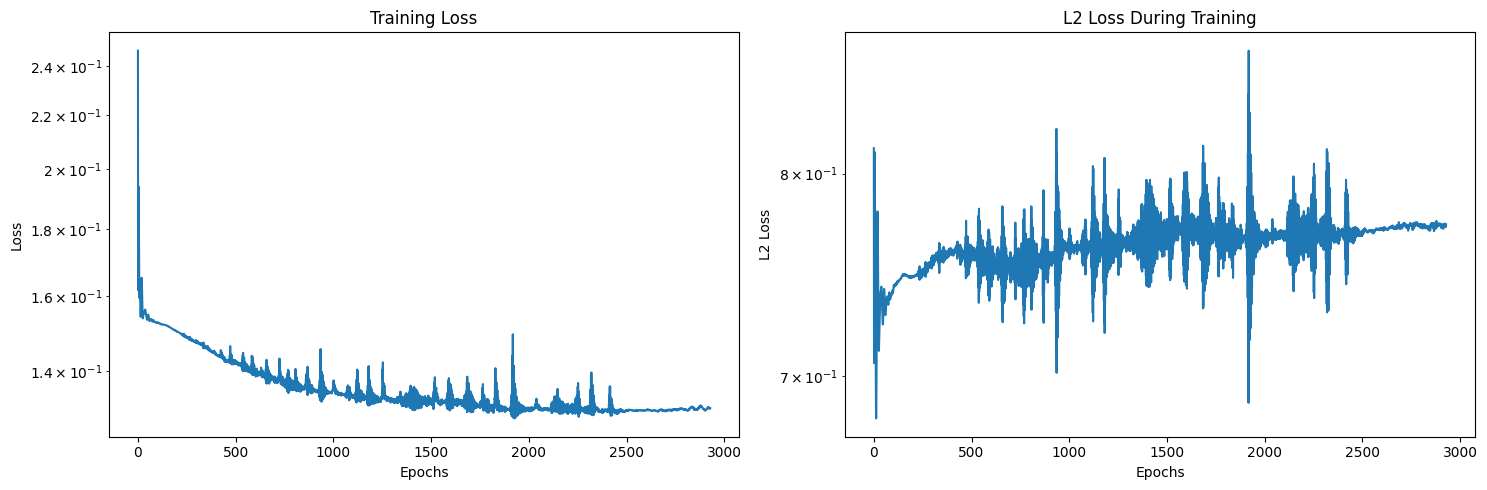

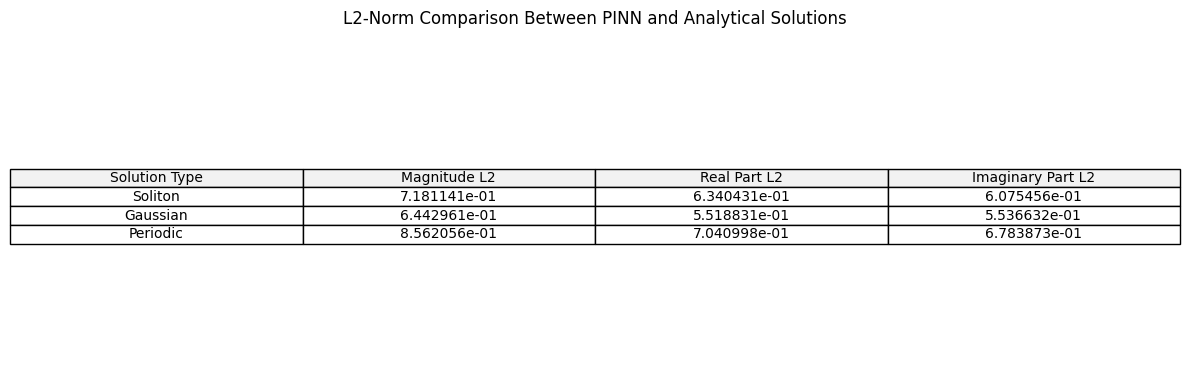

Test Prediction: tensor([[ 0.1164, -0.0905]])
Test Point L2 Norm: 0.66616076


In [15]:
def main():
    model, losses, l2_losses, x, t, psi_initial = train_pinn()
    visualize_results(model, x, t, psi_initial, losses, l2_losses)

    x_test = torch.tensor([[0.5]], dtype=torch.float32)
    t_test = torch.tensor([[0.5]], dtype=torch.float32)
    
    with torch.no_grad():
        prediction = model(x_test, t_test)
        print("Test Prediction:", prediction)
        
        # Calculate L2 norm at test point
        analytical_real, analytical_imag = soliton_solution(x_test.numpy(), t_test.numpy())
        test_l2 = calculate_l2_norm(
            prediction.numpy(), 
            np.array([[analytical_real[0][0], analytical_imag[0][0]]])
        )
        print("Test Point L2 Norm:", test_l2)

if __name__ == "__main__":
    main()